<a href="https://colab.research.google.com/github/Minach2002/sec/blob/master/speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!pip install torch transformers librosa numpy pandas scikit-learn

import dependencies

In [38]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
from IPython.display import Audio

In [39]:
import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model,Wav2Vec2Processor,Trainer,TrainingArguments,Wav2Vec2ForSequenceClassification
import warnings
warnings.filterwarnings('ignore')

Load Dataset

In [40]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import os

dataset_path = '/content/drive/My Drive/Tess-7/TESS'

paths = []
labels = []

for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)

    if os.path.isdir(subfolder_path):

        for filename in os.listdir(subfolder_path):
            if filename.endswith('.wav'):
                file_path = os.path.join(subfolder_path, filename)
                paths.append(file_path)
                labels.append(subfolder)


print(f"Total files: {len(paths)}")
print(f"Sample paths: {paths[:5]}")
print(f"Sample labels: {labels[:5]}")



Total files: 2800
Sample paths: ['/content/drive/My Drive/Tess-7/TESS/sad/OAF_bite_sad.wav', '/content/drive/My Drive/Tess-7/TESS/sad/OAF_bar_sad.wav', '/content/drive/My Drive/Tess-7/TESS/sad/OAF_bean_sad.wav', '/content/drive/My Drive/Tess-7/TESS/sad/OAF_bath_sad.wav', '/content/drive/My Drive/Tess-7/TESS/sad/OAF_beg_sad.wav']
Sample labels: ['sad', 'sad', 'sad', 'sad', 'sad']


In [42]:
print(f"Sample labels: {labels[:5]}")

Sample labels: ['sad', 'sad', 'sad', 'sad', 'sad']


In [43]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/content/drive/My Drive/Tess-7/TESS/sad/OAF_bi...,sad
1,/content/drive/My Drive/Tess-7/TESS/sad/OAF_ba...,sad
2,/content/drive/My Drive/Tess-7/TESS/sad/OAF_be...,sad
3,/content/drive/My Drive/Tess-7/TESS/sad/OAF_ba...,sad
4,/content/drive/My Drive/Tess-7/TESS/sad/OAF_be...,sad


In [44]:
df['label'].value_counts()

,count
label,
sad,400
angry,400
neutral,400
happy,400
fear,400
disgust,400
pleasant_surprised,400


Exploratory Data Analysis

<Axes: xlabel='label', ylabel='count'>

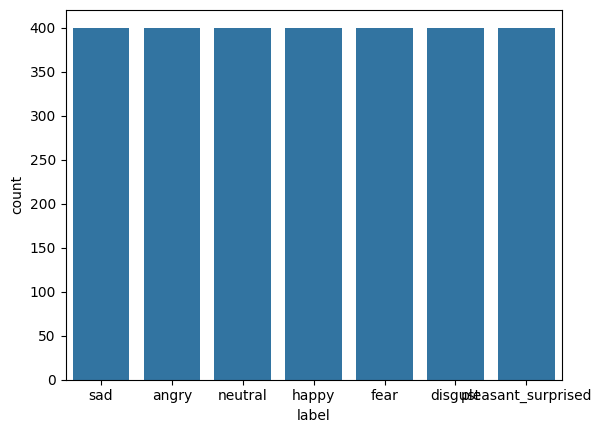

In [45]:
sns.countplot(data=df,x='label')

In [46]:

def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

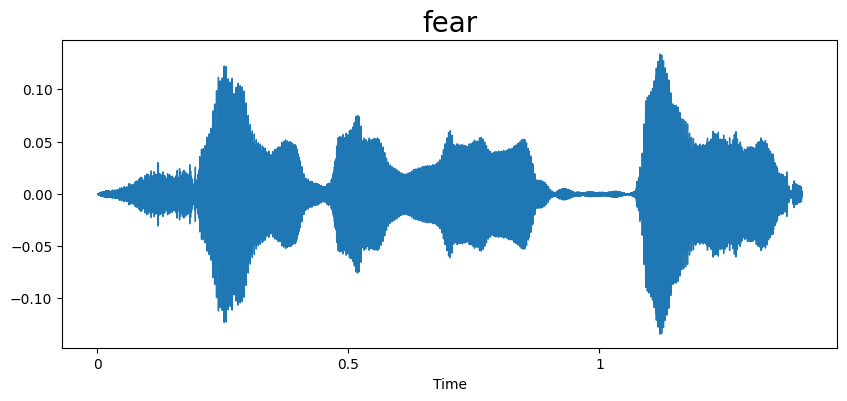

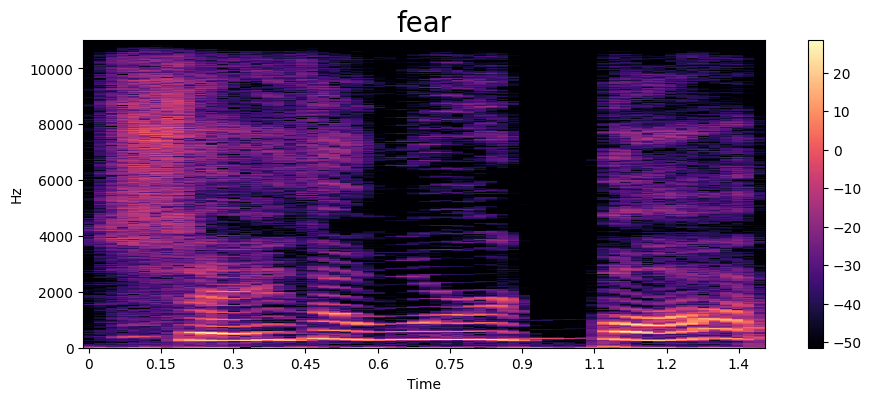

In [47]:
emotion = 'fear'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

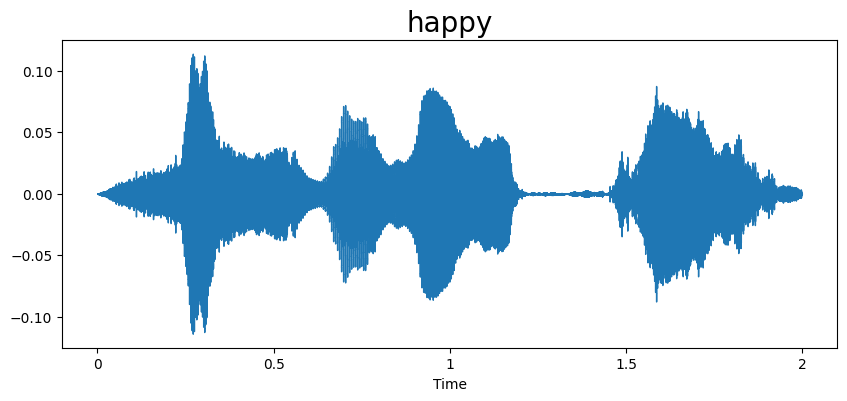

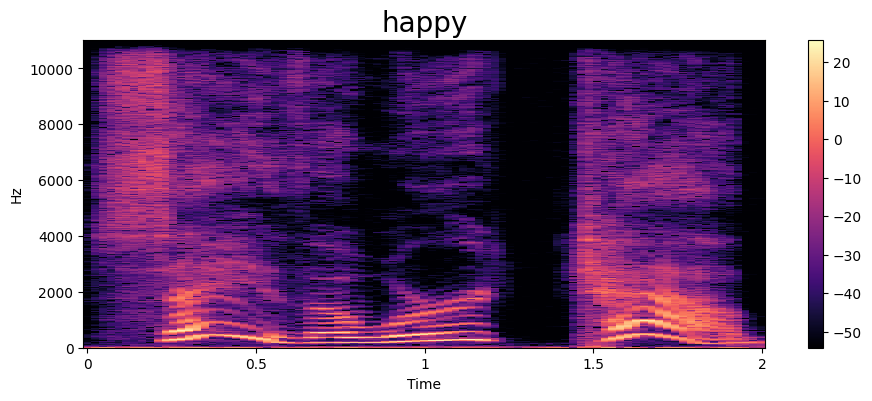

In [48]:
emotion = 'happy'
path = np.array(df['speech'][df['label']==emotion])[1]
data,sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)


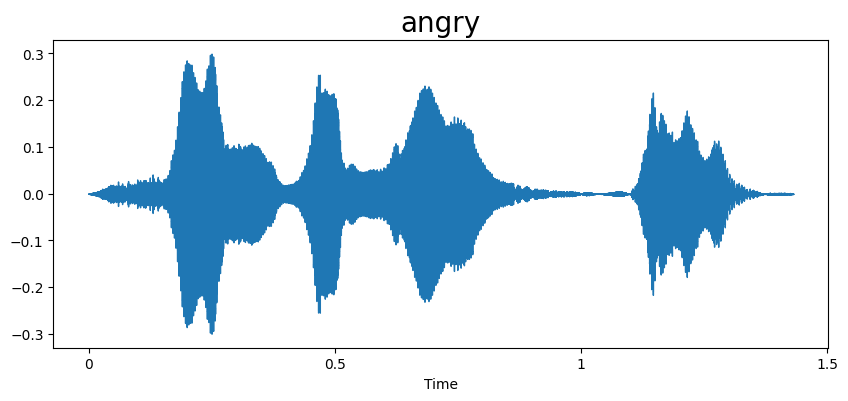

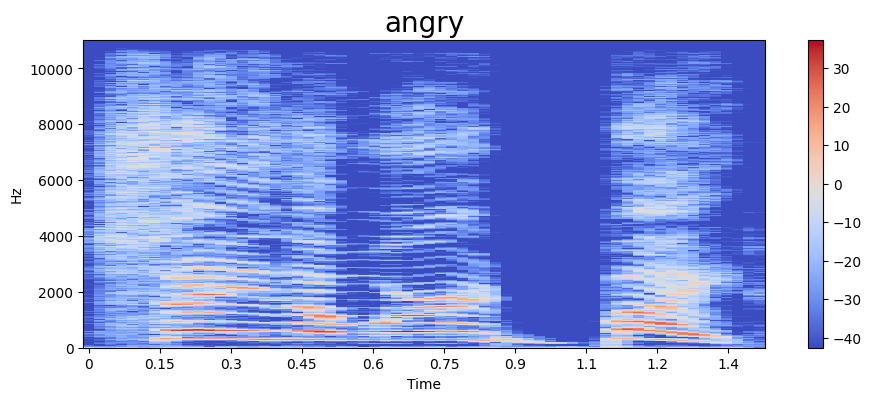

In [49]:
emotion = 'angry'
path = np.array(df['speech'][df['label']==emotion])[1]
data,sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

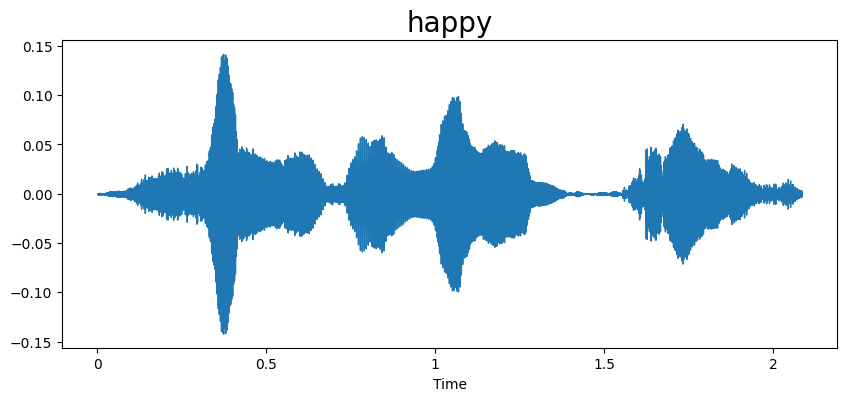

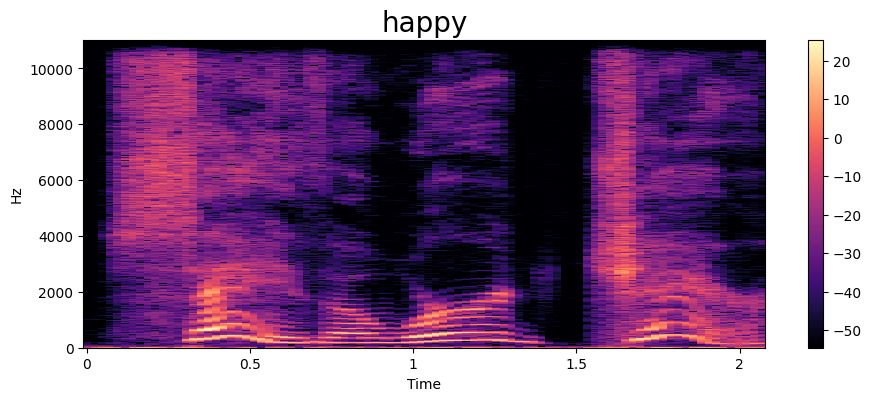

In [50]:
emotion = 'happy'
path = np.array(df['speech'][df['label']==emotion])[0]
data,sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)


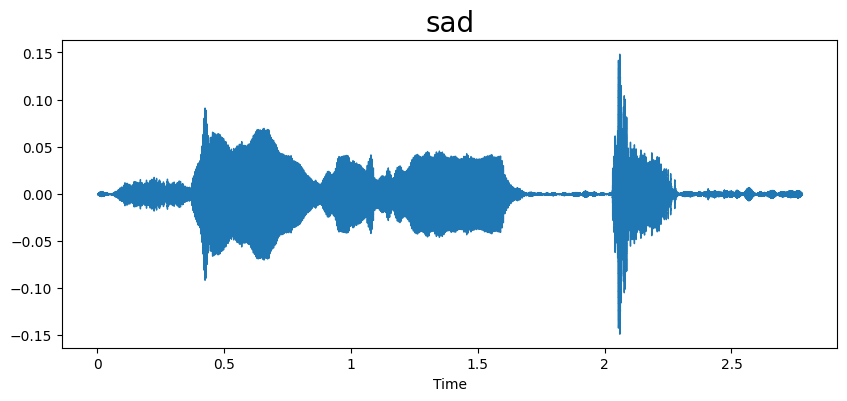

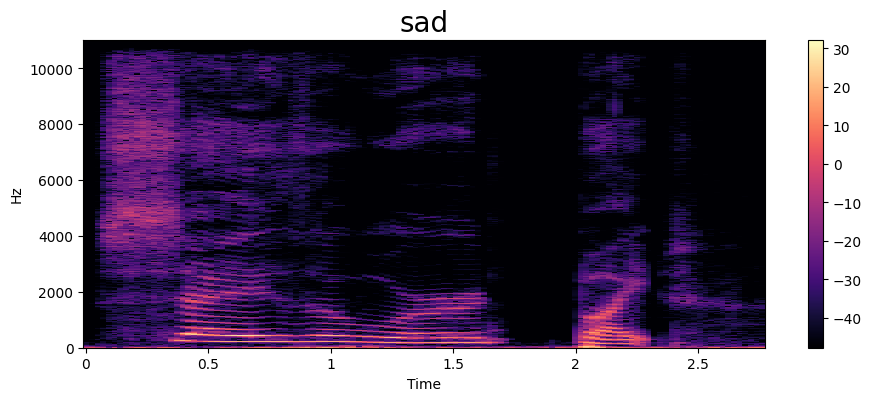

In [51]:
emotion = 'sad'
path = np.array(df['speech'][df['label']==emotion])[0]
data,sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

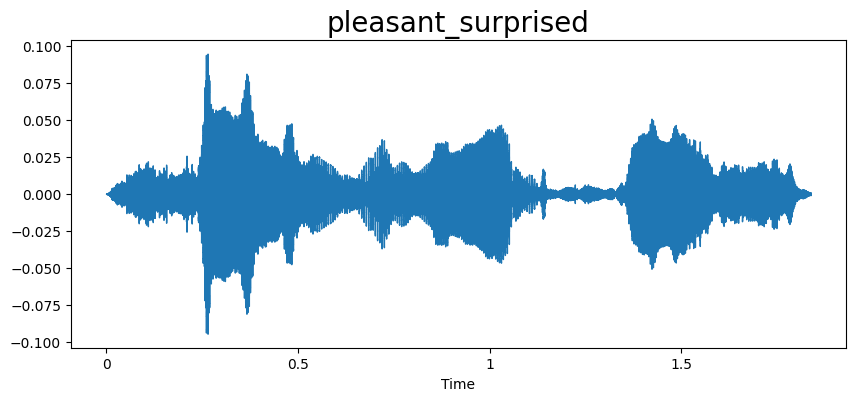

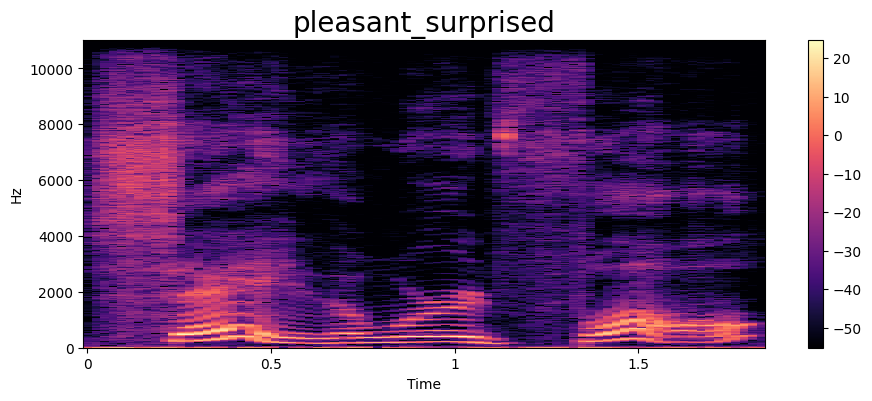

In [52]:
emotion = 'pleasant_surprised'
path = np.array(df['speech'][df['label']==emotion])[0]
data,sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

Create custome Dataset class

In [53]:
label_map = {label: idx for idx, label in enumerate(df['label'].unique())}
inverse_label_map = {idx: label for label, idx in label_map.items()}
df['label'] = df['label'].map(label_map)
df.head(2)

,speech,label
0,/content/drive/My Drive/Tess-7/TESS/sad/OAF_bi...,0
1,/content/drive/My Drive/Tess-7/TESS/sad/OAF_ba...,0


In [54]:
emotion = 'pleseant_surprised'
path = np.array(df['speech'][df['label']==2])[0]
data,sampling_rate = librosa.load(path)
print(len(data))
sampling_rate * 2

48824


44100

In [69]:
class SpeechEmotionDataset(Dataset):
    def __init__(self, df, processor, max_length=32000):
        self.df = df
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['speech']
        label = self.df.iloc[idx]['label']

        # load the audio file
        speech, sr = librosa.load(audio_path, sr=16000)

        # truncate the speech to the required length
        if len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech, (0, self.max_length - len(speech)), 'constant')

        # preprocess the audio files
        inputs = self.processor(speech, sampling_rate=16000, return_tensors='pt', padding=True, truncation=True, max_length=self.max_length)


        input_values = inputs.input_values.squeeze()
        return {'input_values': input_values, 'label': torch.tensor(label, dtype=torch.long)}


In [70]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [71]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=7)


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [78]:
#load datset
train_dataset = SpeechEmotionDataset(train_df, processor)
test_dataset = SpeechEmotionDataset(test_df, processor)

In [79]:
train_dataset[0]['input_values'].size()

torch.Size([32000])

set training arguments

In [80]:
training_args =  TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to=[]

)

In [81]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels= pred.label_ids
    preds= np.argmax(pred.predictions, axis=1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
#initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.635400,0.987500,0.987451,0.988222,0.987500
